# Praca domowa nr 5
**Marceli Korbin**

Celem pracy jest przetestowanie dwóch metod XAI na sieci przewidującej zawartość zdjęcia.

In [1]:
import keras
from keras.applications import resnet50
resnet = resnet50.ResNet50(weights='imagenet')

W tej pracy wykorzystam sieć **ResNet50**. Jest ona złożona z kilku poziomów, wykorzystujących liczne warstwy konwolucji, podzielone w bloki konwolucyjne i tożsamościowe. Jej główną charakterystyką jest wykorzystanie specjalnych połączeń skrótowych, które pozwalają sieci na nauczenie się funkcji identyczności gwarantującej lepszą lub tak samo dobrą wydajność na wyższych warstwach względem niższych. Ponadto te skrótowce łagodzą problem zerującego się gradientu, pozwalając na jego szybszy przepływ.

źródło: P. Dwivedi, *Understanding and Coding a ResNet in Keras*, Towards Data Science https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

### Algorytm Grad-CAM (+ przykład 0: słoń)

źródło kodu: Chollet F., _Grad-CAM class activation visualization_ (https://github.com/keras-team/keras-io/blob/master/examples/vision/grad_cam.py)

Przedstawiam oryginalny kod w celu przybliżenia sposobu jego użycia i wykorzystania kilku bardzo przydatnych funkcji.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

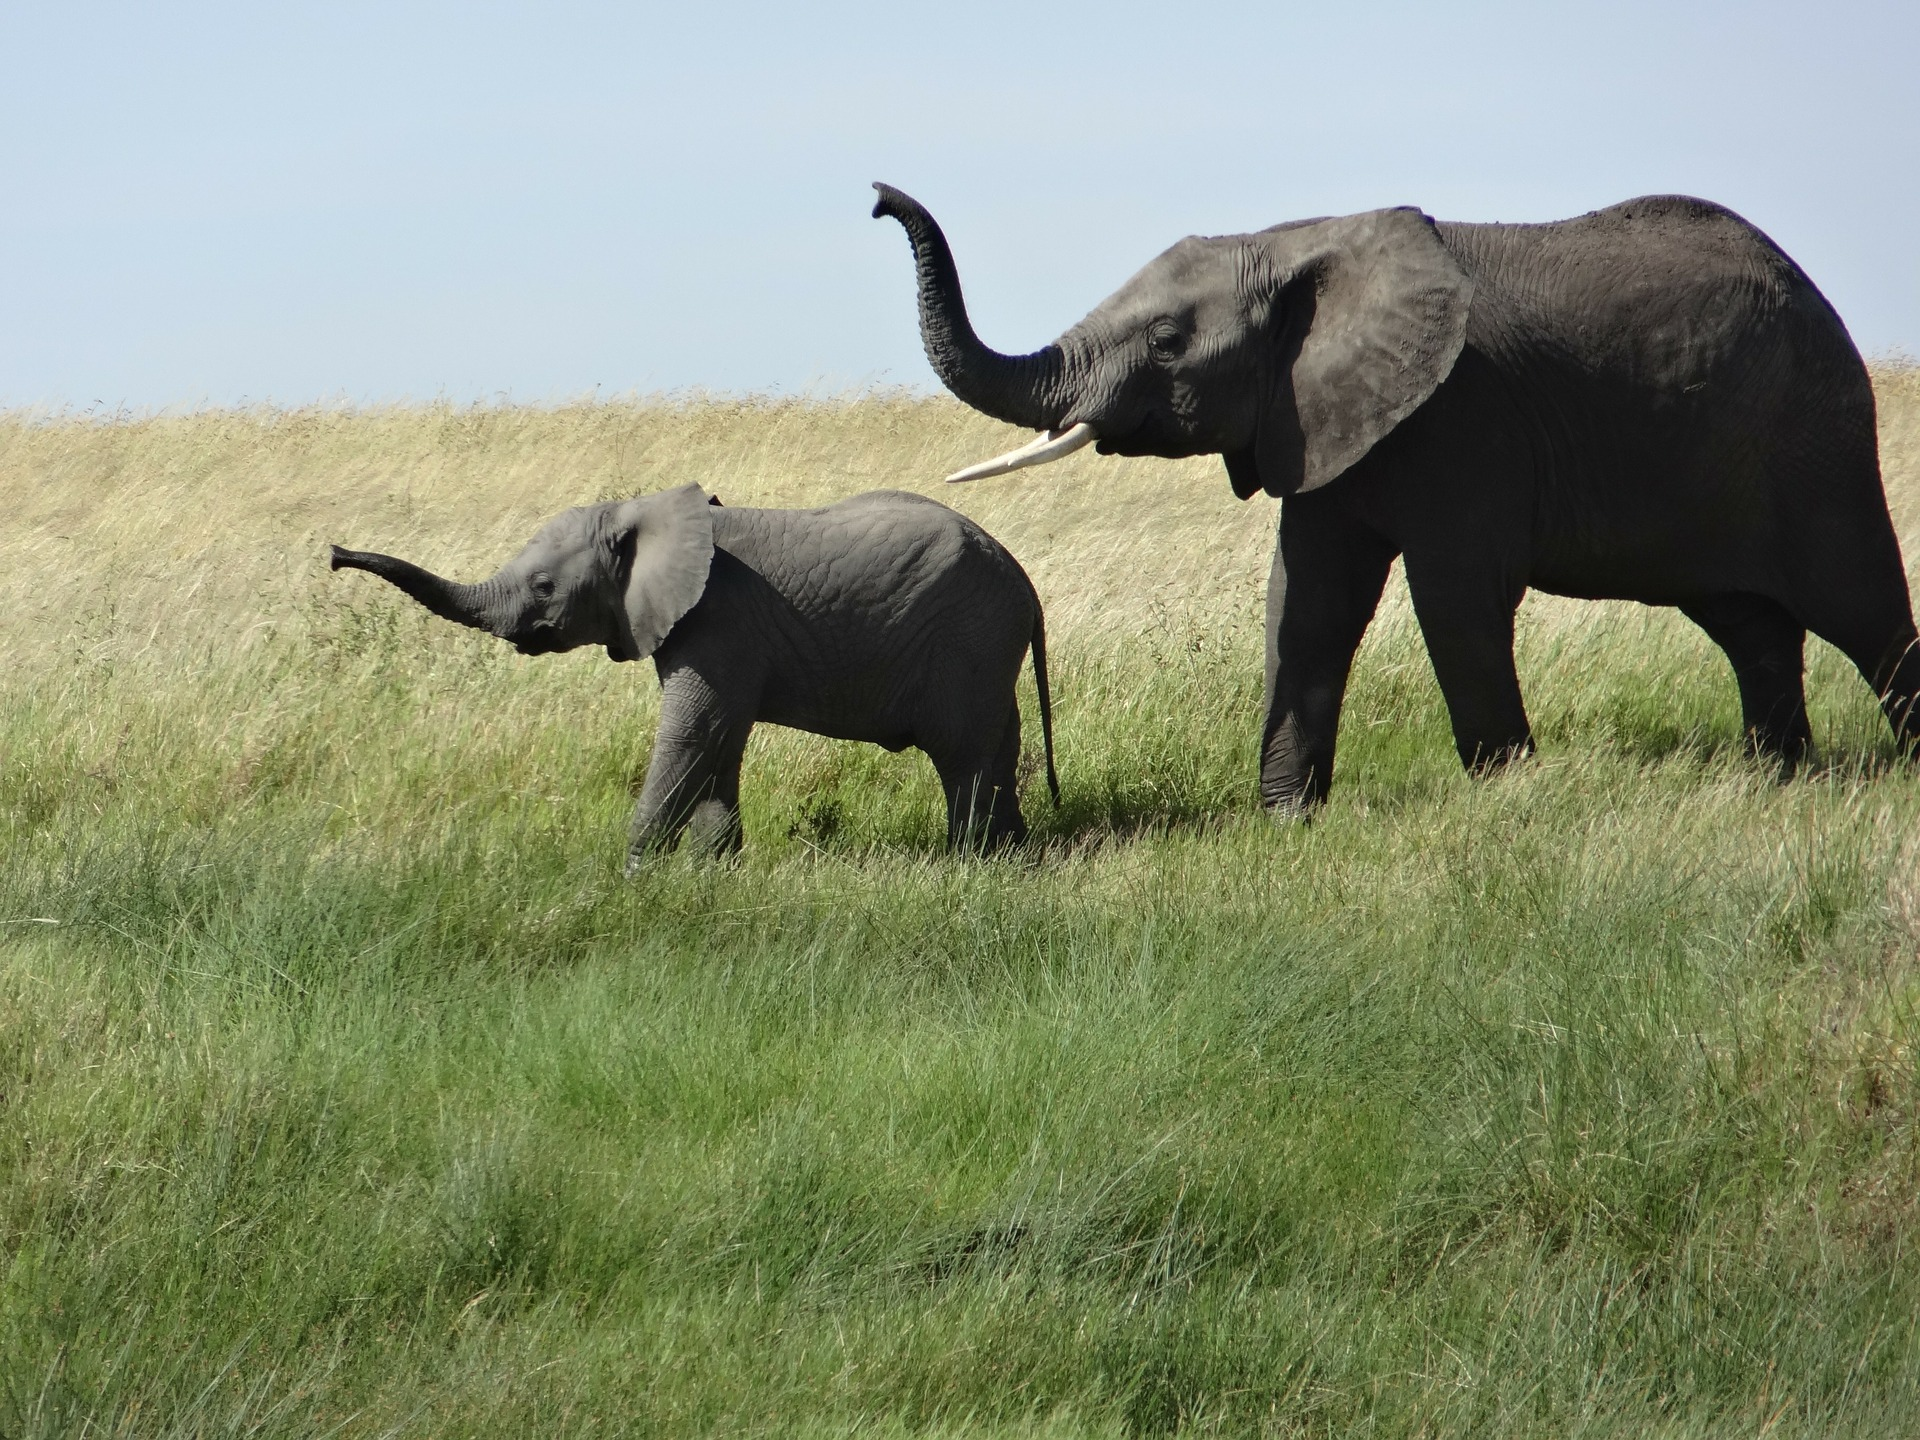

In [3]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: [('n02504458', 'African_elephant', 9.862387)]


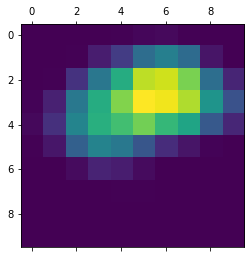

In [5]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

### Algorytm Lime

źródło kodu: yohanb, _Explaining Keras Model with LIME_ (https://www.kaggle.com/yohanb/explaining-keras-model-with-lime)

In [6]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

explainer = lime_image.LimeImageExplainer(random_state=42)

## Przykład 1: perkusja

Pierwszym przykładem będzie zdjęcie perkusji... z sylwetką Jimiego Hedrixa w tle.

źródło: https://perkusje.org/tag/perkusja-2/

In [7]:
perkusja = keras.preprocessing.image.load_img("perkusja.jpg")

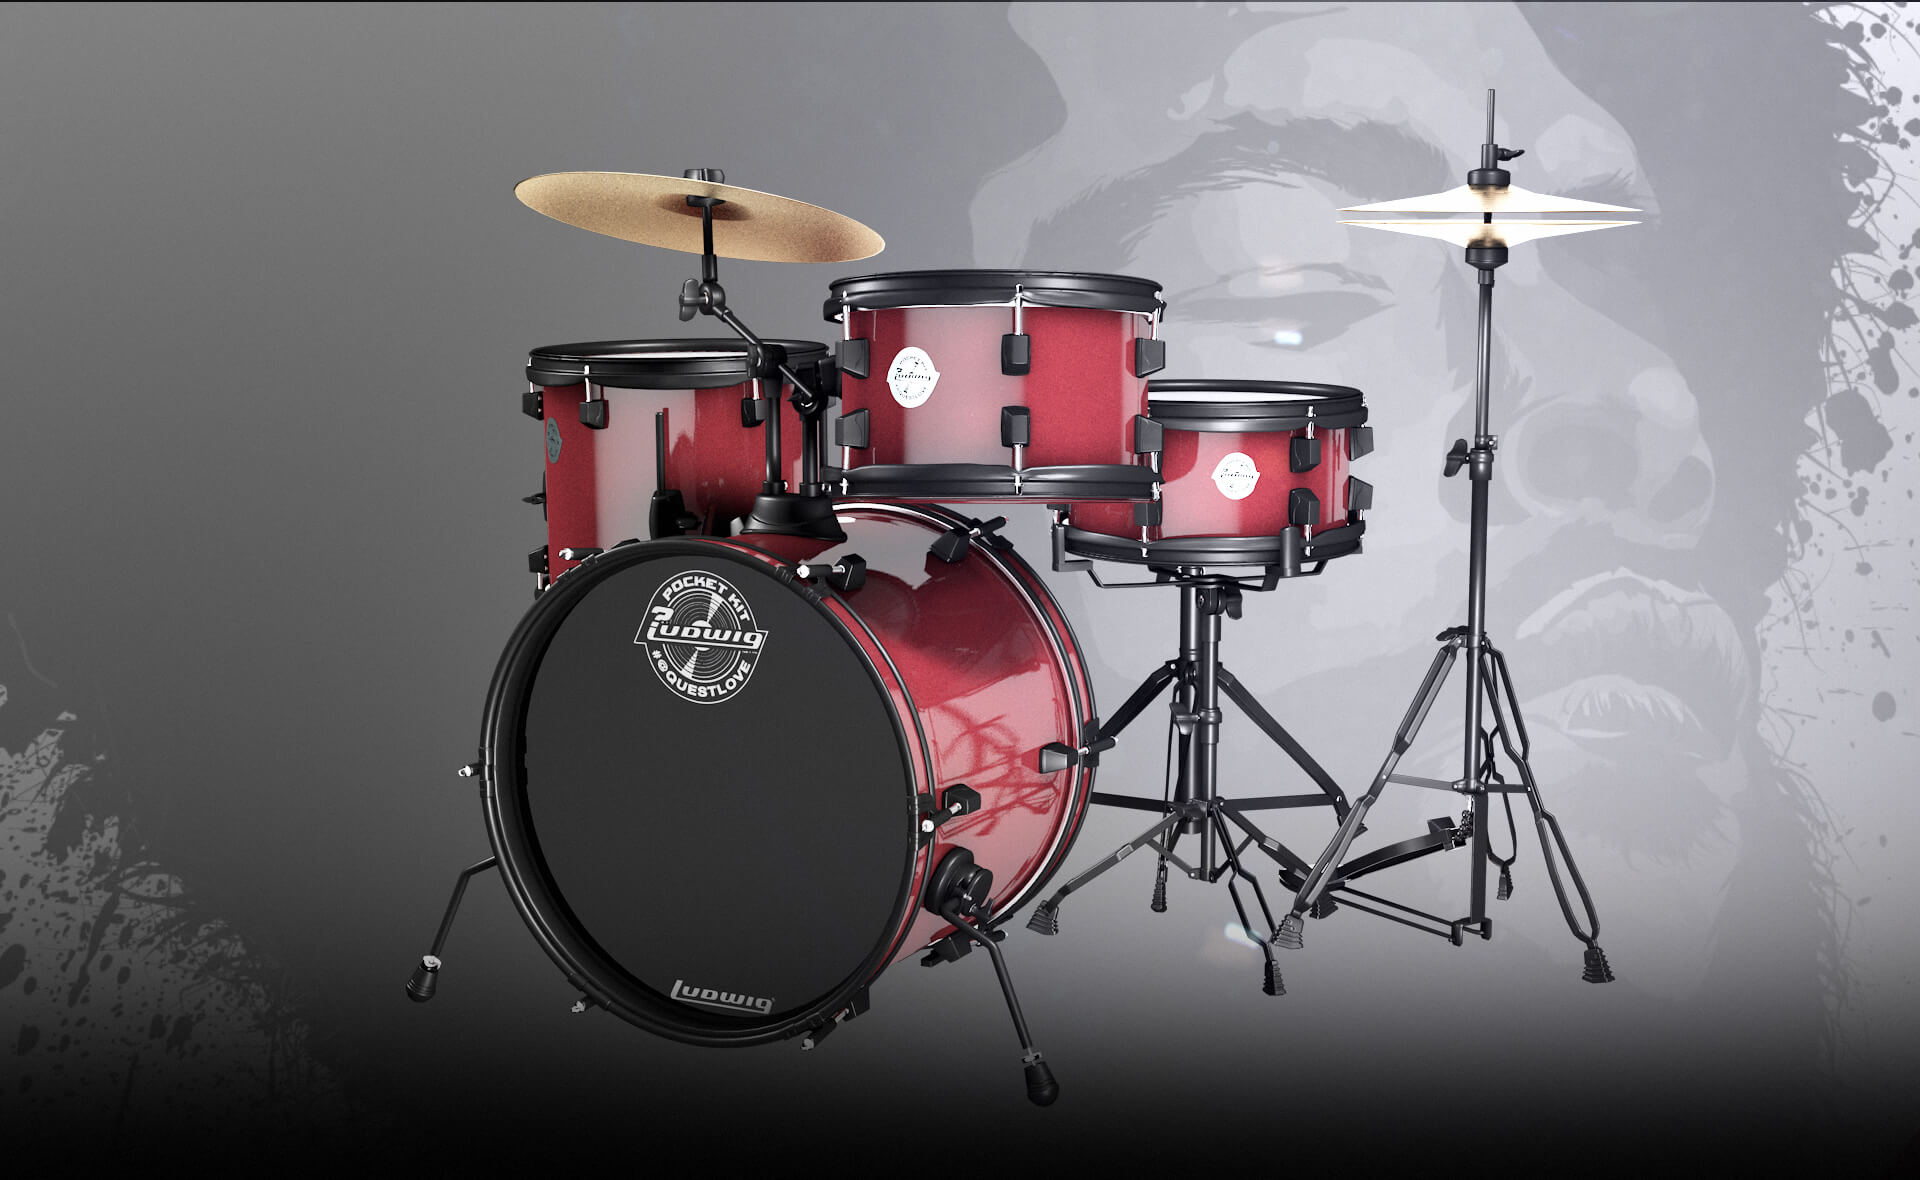

In [8]:
display(perkusja)

Do utworzenia mapy Grad-CAM będziemy potrzebować nazwy ostatniej konwolucyjnej warstwy. Pogrzebmy w ostatnich 15 warstwach modelu:

In [9]:
print([layer.name for layer in resnet.layers[-15:]])

['conv5_block2_3_bn', 'conv5_block2_add', 'conv5_block2_out', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out', 'avg_pool', 'predictions']


Szukana warstwa nazywa się *conv5_block3_3_conv*.

In [10]:
warstwa = 'conv5_block3_3_conv'

Nauczmy sieć i sprawdźmy, co powie:

In [11]:
rozmiar = (224, 224)
preprocess_input = keras.applications.resnet50.preprocess_input
decode_predictions = keras.applications.resnet50.decode_predictions
perkusja_array = preprocess_input(get_img_array("perkusja.jpg", size=rozmiar))
perkusja_pred = resnet.predict(perkusja_array)
print("Predicted:", decode_predictions(perkusja_pred, top=1)[0])

Predicted: [('n03249569', 'drum', 0.659529)]


Bęben! Jest tych bębnów wprawdzie więcej, ale Grad-CAM się nie pomylił w rozpoznaniu przedmiotu na zdjęciu. A dlaczego tak?

### Grad-CAM

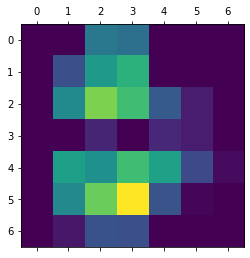

In [12]:
heatmap = make_gradcam_heatmap(perkusja_array, resnet, warstwa)
plt.matshow(heatmap)
plt.show()

Algorytm Grad-MAP wskazuje prawidłowo na bębny na górze i na dole. Sieć słusznie zignorowała Hendrixa w tle.

### Lime

c:\users\marceli\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'wytłumaczenie')

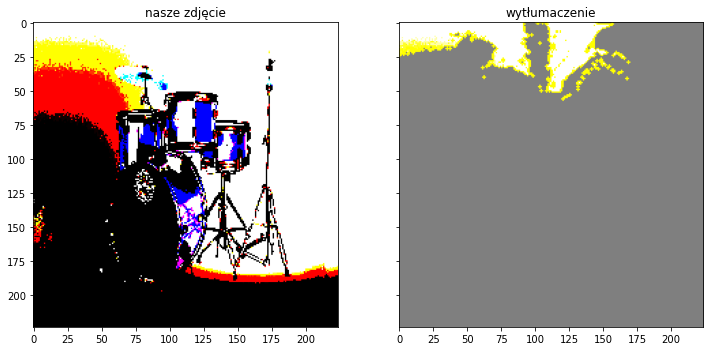

In [25]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_figwidth(12)
fig.set_figheight(6)
explanation = explainer.explain_instance(perkusja_array[0].astype('double'), resnet.predict,
                                         top_labels=1, hide_color=0, num_samples=1, random_seed=42)
ax[0].imshow(perkusja_array[0])
ax[0].set_title("nasze zdjęcie")
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=True)
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title("wytłumaczenie")

Według Lime, perkusję rozpoznano na podstawie... talerzy?

## Przykład 2: tort z misiem i pluszowy miś

Docelowo czy nie, trochę skomplikujemy rzeczy.

źródło: https://gotujmy.pl/tort-brzoskwiniowy-z-misiem,przepisy-dla-dzieci-przepis,264907.html

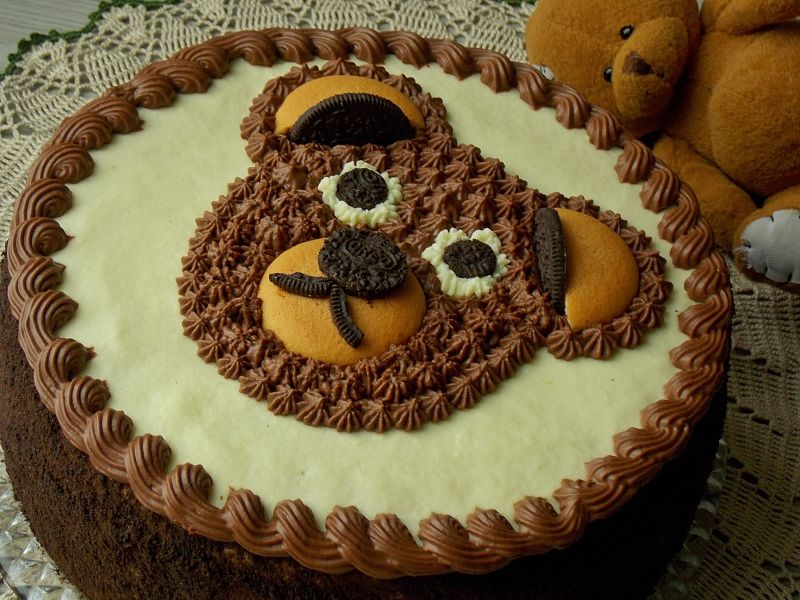

In [27]:
tort = keras.preprocessing.image.load_img("torcik.jpg")
display(tort)

In [28]:
tort_array = preprocess_input(get_img_array("torcik.jpg", size=rozmiar))
tort_pred = resnet.predict(tort_array)
print("Predicted:", decode_predictions(tort_pred, top=1)[0])

Predicted: [('n02799071', 'baseball', 0.20139973)]


Że co? Piłka bejsbolowa? Gdzie?

### Grad-CAM

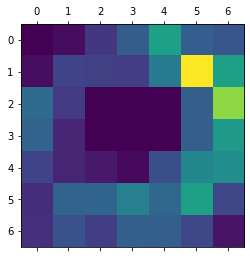

In [29]:
heatmap2 = make_gradcam_heatmap(tort_array, resnet, warstwa)
plt.matshow(heatmap2)
plt.show()

Najjaśniejszy kwadrat znajduje się w miejscu, gdzie widać pluszowego misia. A zatem szczegół z tła zaburzył całość.

### Lime

c:\users\marceli\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'wytłumaczenie')

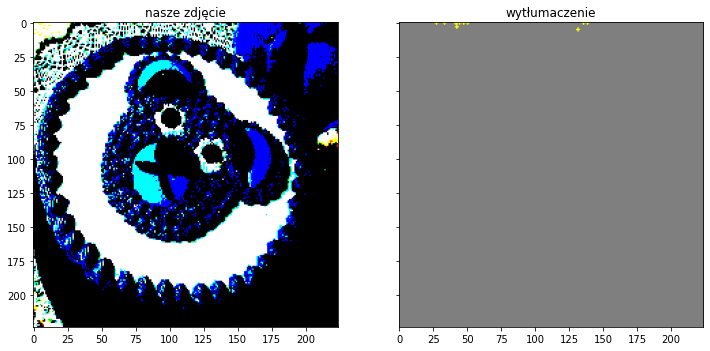

In [32]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_figwidth(12)
fig.set_figheight(6)
explanation2 = explainer.explain_instance(tort_array[0].astype('double'), resnet.predict,
                                         top_labels=1, hide_color=0, num_samples=1, random_seed=42)
ax[0].imshow(tort_array[0])
ax[0].set_title("nasze zdjęcie")
temp, mask = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=False, hide_rest=True)
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title("wytłumaczenie")

Algorytm Lime nawet nie znalazł argumentu na piłkę bejsbolową. Czyli nasz ResNet najprawdopodobniej zgłupiał.

## Wnioski

Algorytmy Grad-CAM i Lime miały wytłumaczyć zachowanie sieci neuronowej wykrywającej obiekty na obrazku. Grad-CAM posłusznie mówi, gdzie został / mógł zostać znaleziony dany obiekt, a Lime tłumaczy to samo dość nieśmiało, chociaż potrafi pokazać brak "alibi" w wypadku złej predykcji.